In [1]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve, recall_score, precision_score, confusion_matrix, average_precision_score

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#data_features consists of lumisections from JetHT, wich are preprocessed:

# 1) samples with low lumi were deleted: 
# nonempty = np.where(data["lumi"] >= 0.01)[0]
# data = data.iloc[nonempty]

# 2) columns with std=0 were removed
# cols = data.select_dtypes([np.number]).columns
# std = data[cols].std()
# cols_to_drop = std[std==0].index
# data = data.drop(cols_to_drop, axis=1)

# 3) standard scaler was applied for all features

data_features = pd.read_hdf('/home/olgako/data/data_features_JetHT.hdf5', "data")
labels = pd.read_hdf('/home/olgako/data/labels_JetHT.hdf5', 'labels')

In [4]:
one_fifth = int(data_features.shape[0]/5)
step = int(data_features.shape[0]/10)
whole = data_features.shape[0]

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_features=scaler.fit_transform(data_features)

In [6]:
def get_error_df(X_test, predictions, y_test, mode='None', n_highest = 100):
    if mode=='allmean':
        mse = np.mean(np.power(X_test - predictions, 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})        
        return error_df
    elif mode=='topn':
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        mse = np.mean(result, axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})
        return error_df


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
tf.set_random_seed(0)
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [8]:
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.layers.advanced_activations import PReLU, LeakyReLU
from sklearn.utils import shuffle
import h5py

In [9]:
input_dim = data_features.shape[1]
encoding_dim = 50

In [10]:
def buildAE():
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation='linear')(input_layer)
    encoder = LeakyReLU(alpha=.1)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    return Model(inputs=input_layer, outputs=decoder)   

In [11]:
buildAE().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2470)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                123550    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2470)              125970    
Total params: 249,520
Trainable params: 249,520
Non-trainable params: 0
_________________________________________________________________


In [12]:
nb_epoch = 20
batch_size = 512

Train on 115783 samples, validate on 12865 samples
Epoch 1/20
115783/115783 [==============================] - 3s - loss: 0.4550 - val_loss: 0.4357
Epoch 2/20
115783/115783 [==============================] - 3s - loss: 0.4350 - val_loss: 0.4346
Epoch 3/20
115783/115783 [==============================] - 3s - loss: 0.4344 - val_loss: 0.4343
Epoch 4/20
115783/115783 [==============================] - 3s - loss: 0.4342 - val_loss: 0.4340
Epoch 5/20
115783/115783 [==============================] - 2s - loss: 0.4338 - val_loss: 0.4337
Epoch 6/20
115783/115783 [==============================] - 3s - loss: 0.4334 - val_loss: 0.4332
Epoch 7/20
115783/115783 [==============================] - 2s - loss: 0.4330 - val_loss: 0.4328
Epoch 8/20
115783/115783 [==============================] - 3s - loss: 0.4328 - val_loss: 0.4326
Epoch 9/20
115783/115783 [==============================] - 2s - loss: 0.4326 - val_loss: 0.4323
Epoch 10/20
115783/115783 [==============================] - 3s - loss: 0.43

115318/115318 [==============================] - 3s - loss: 0.4535 - val_loss: 0.4369
Epoch 2/20
115318/115318 [==============================] - 3s - loss: 0.4352 - val_loss: 0.4351
Epoch 3/20
115318/115318 [==============================] - 3s - loss: 0.4341 - val_loss: 0.4342
Epoch 4/20
115318/115318 [==============================] - 2s - loss: 0.4337 - val_loss: 0.4338
Epoch 5/20
115318/115318 [==============================] - 3s - loss: 0.4334 - val_loss: 0.4336
Epoch 6/20
115318/115318 [==============================] - 2s - loss: 0.4332 - val_loss: 0.4333
Epoch 7/20
115318/115318 [==============================] - 3s - loss: 0.4328 - val_loss: 0.4329
Epoch 8/20
115318/115318 [==============================] - 2s - loss: 0.4324 - val_loss: 0.4326
Epoch 9/20
115318/115318 [==============================] - 3s - loss: 0.4322 - val_loss: 0.4324
Epoch 10/20
115318/115318 [==============================] - 2s - loss: 0.4320 - val_loss: 0.4322
Epoch 11/20
115318/115318 [=============

115670/115670 [==============================] - 3s - loss: 0.4546 - val_loss: 0.4373
Epoch 2/20
115670/115670 [==============================] - 3s - loss: 0.4359 - val_loss: 0.4348
Epoch 3/20
115670/115670 [==============================] - 3s - loss: 0.4351 - val_loss: 0.4328
Epoch 4/20
115670/115670 [==============================] - 3s - loss: 0.4348 - val_loss: 0.4323
Epoch 5/20
115670/115670 [==============================] - 2s - loss: 0.4345 - val_loss: 0.4317
Epoch 6/20
115670/115670 [==============================] - 3s - loss: 0.4342 - val_loss: 0.4313
Epoch 7/20
115670/115670 [==============================] - 2s - loss: 0.4339 - val_loss: 0.4309
Epoch 8/20
115670/115670 [==============================] - 3s - loss: 0.4335 - val_loss: 0.4306
Epoch 9/20
115670/115670 [==============================] - 3s - loss: 0.4333 - val_loss: 0.4304
Epoch 10/20
115670/115670 [==============================] - 3s - loss: 0.4331 - val_loss: 0.4301
Epoch 11/20
115670/115670 [=============

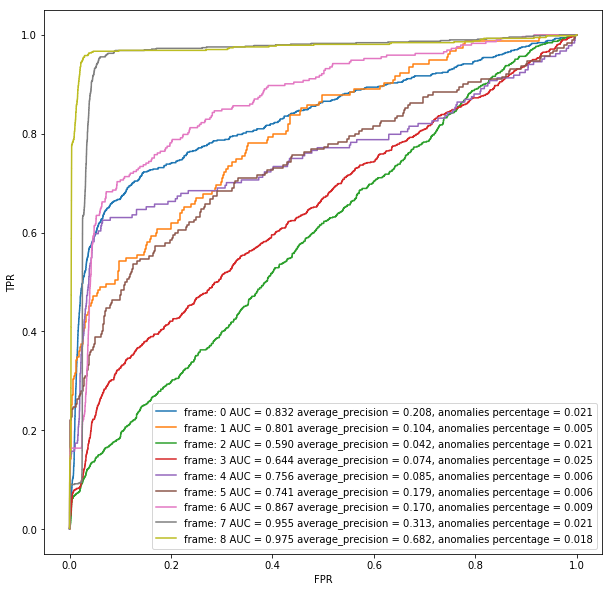

In [13]:
plt.figure(figsize=(10, 10))

imp_features = []
for i in range(9):
    indx_test = np.arange(i*step, one_fifth+i*step)
    indx_train = list(set(range(whole))-set(indx_test))
    
    
    y_train = np.array(labels.iloc[indx_train], 'float32')
    y_test = np.array(labels.iloc[indx_test], 'float32')

    X_train = np.array(data_features[indx_train], 'float32')
    X_test = np.array(data_features[indx_test], 'float32')

    
    start_time = time.time()
    
    autoencoder = buildAE()
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
    autoencoder.fit(X_train[y_train==0.], 
                    X_train[y_train==0.],
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    initial_epoch=0)    
    
    print("--- %s seconds ---" % (time.time() - start_time))
    

    predictions = autoencoder.predict(X_test)
    error_df = get_error_df(pd.DataFrame(X_test), pd.DataFrame(predictions), y_test, mode='topn', n_highest = 300)
    
    

    fpr, tpr, _ = roc_curve(error_df.true_class, error_df.reconstruction_error)
    average_precision = average_precision_score(error_df.true_class, error_df.reconstruction_error)
    auc_score = roc_auc_score(error_df.true_class, error_df.reconstruction_error)
    
    percent = np.sum(y_test)/np.float(len(y_test))
    plt.plot(fpr, tpr, label= "frame: "+np.str(i)+' AUC = %.3lf' % auc_score+' average_precision = %.3lf' % average_precision +', anomalies percentage = %.3lf' % percent)
    
    
plt.legend(loc='lower right', fontsize=10)

plt.xlabel('FPR', fontsize=10)
plt.ylabel('TPR', fontsize=10)
plt.show()

In [14]:
from evaluation import *

P@10 1.0
recalls_values [0.8, 0.9, 0.95, 0.99]
precision_values [0.60498687664041995, 0.47702205882352944, 0.39409221902017288, 0.02148997134670487]
average_precision_score 0.682127627699
roc_auc_score 0.974657426931


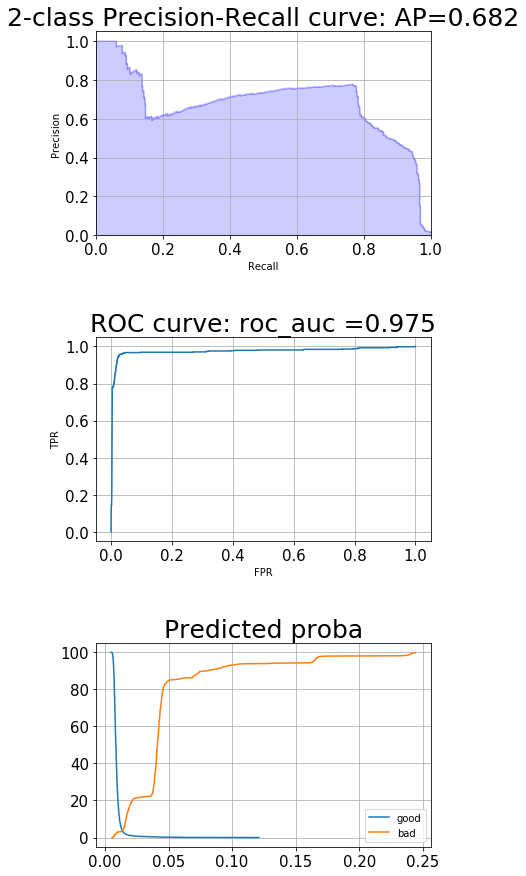

In [15]:
ps, rs = perfomance(error_df.true_class, error_df.reconstruction_error)